# 3D EFIT Rail Code in MPI

## Combined Zane structure, Eric MPI, My system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import time
import functools

#from distBox import distBox

import sys
#from mpi4py import MPI
from os import environ 
from typing import *                     
import matplotlib.animation as animation

In [8]:
test = np.zeros((3,3,3))

In [10]:
np.shape(test)

(3, 3, 3)

In [21]:
test

array([[[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]],

       [[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.]],

       [[ 3.,  6.,  9.],
        [12., 15., 18.],
        [21., 24., 27.]]])

In [27]:
tests = np.array([0,2,1])

In [28]:
test[tests]


array([[[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]],

       [[ 3.,  6.,  9.],
        [12., 15., 18.],
        [21., 24., 27.]],

       [[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.]]])

In [1]:
#MPIComm = Union[MPI.Intracomm, MPI.Intercomm]
#mpi_comm = MPI.COMM_WORLD
#myid = mpi_comm.Get_rank()                                                         
#mpi_size = mpi_comm.Get_size()        
nprocs=1 #mpi_size
myid = 0

# for overlapping slabs:  
# # points per proc along z = npz = gh1/nproc (+2 to ghost boundaries)
# glob_index = loc_index-1 + npz*myid
# loc_index = glob_index - npz*myid + 1
# myid given glob_index = glob_index/npz = ghloc-2

# set Constants
AirCut = True
RailShape = True

#Dimmesnsion of simulation space in meters
length1 = 1.0
width1 = 0.1524
height1 = 0.1524

#Image Folder
imFolder = '/sciclone/scr10/dchendrickson01/EFIT/'

#is the rail supported by 0, 1 or 2 ties
Ties = 2

#Choose ferquency to be used for excitment
frequency = 16300
frequency = 2000


#Run for 4 Cycles:
runtime = 1 / frequency 

#Forcing Function Location and type
# 1 for dropped wheel on top
# 2 for rubbing flange on side
FFunction = 2

#MATERIAL 1 ((steel))
pRatio1 = 0.29                                    #poission's ratio in 
yModulus1 = 200 * (10**9)                           #youngs modulus in pascals
rho1 = 7800                                        #density in kg/m^3


#CALCULATED PARAMETERS FROM INPUTS

#Image Folder
if FFunction == 1:
    imFolder += 'TopHit/'
elif FFunction == 2:
    imFolder += 'SideRub/'

WheelLoad = 173000 #crane force in Neutons

#MATERIAL 2  (air)
pRatio2= 0.98
yModulus2= 1.13*(10**5)
rho2 = 1.15       
mu2 = yModulus2/(2*(1+pRatio2))                    
lmbda2 = abs(2 * mu2 * pRatio2 / (1 - 2 * pRatio2))

mu1 = yModulus1/(2*(1+pRatio1))                    #second Lame Parameter
lmbda1 = 2 * mu1 * pRatio1 / (1 - 2 * pRatio1)     #first Lame Parameter

#Calculate speed of longitudinal and transverse waves in material 1
cl1 = np.sqrt((lmbda1 + 2* mu1)/rho1)
ct1 = np.sqrt(mu1/rho1)

#calculate wave lengths for material 1
omegaL1 = cl1 / frequency
omegaT1 = ct1 / frequency

#Calculate speed of longitudinal and transverse waves in material 1
cl2= np.sqrt((lmbda2 + 2* mu2)/rho2)
ct2 = np.sqrt(mu2/rho2)

if myid == 0:
    print('material 2 wave speeds:' ,cl2,ct2)

#calculate wavelengths in material 2
omegaL2 = cl2 / frequency
omegaT2 = ct2 / frequency

#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
#ts = 1 / frequency / 10    #time step
gs = (min(omegaL1, omegaT1,omegaL2,omegaT2) /12)    #grid step
ts = gs/((max(cl1,ct1,cl2,ct2))*(np.sqrt(3)))*0.95 #time step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time Steps

#number of grid points
gl1 = int(math.ceil(length1 / gs)) +1       #length 
gw1 = int(math.ceil(width1 / gs)) +1       #width
gh1 = int(math.ceil(height1 / gs)) +1       #height

frequency = 16355

# Keep these as the global values
xmax=gl1-1
ymax=gw1-1
zmax=gh1-1

## for latter rail section, define the dimmmensions in terms of grid
HeadThickness = 0.05
WebThickness = 0.035
FootThickness = 0.03
HeadWidth = 0.102

relHeadThick = HeadThickness / height1
relWeb = WebThickness / width1
relFoot = FootThickness / height1
relHeadWidth = HeadWidth / width1

relStartHeadThick = 1 - relHeadThick
relStartWeb = 0.5 - (relWeb / 2.0)
relEndWeb = 0.5 + (relWeb / 2.0)
relStartHeadWidth = 0.5 - (relHeadWidth / 2.0)
relEndHeadWidth = 0.5 + (relHeadWidth / 2.0)


gridStartHead = round(gh1 * relStartHeadThick)
gridStartWeb = round(gw1 * relStartWeb)
gridEndWeb = round(gw1 * relEndWeb)
gridEndFoot = round(gh1 * relFoot)
gridStartHeadWidth = round(gw1 * relStartHeadWidth)
gridEndHeadWidth = round(gw1  * relEndHeadWidth)


#####

#MPI EJW Section 1
#extend the length of the beam so that the number of nodes in the x dimmension 
#is the evenly divisible by the number of processors
if (gl1 % nprocs) != 0:
    gl1 += nprocs - (gl1 % nprocs)

#check you did it right
if (gl1 % nprocs) != 0:
    if myid == 0:
        print("Hey, gl1 not divisible by nproc",gl1,nprocs)
        sys.exit()
npx=int(gl1/nprocs)


if myid == 0:
    print("gl1,npx,nproc",gl1,npx,nprocs)

#print(runtime, ts, gs, Tsteps, gl, gh)

if myid == 0:
    print('runtime (s), time step size (s), total # of time steps:', runtime, ts, Tsteps)
    print('grid step size, # of length pts, # of height pts, # of width pts, gl1 loc pts:', gs,gl1,gw1,gh1,npx)

#tensor to store material properties for each point
#0 index is density
#1 index is first Lame Parmaeter
#2 index is second lame parameter

#MPI EJW Section 2 changes
matPropsglob=np.zeros((4,gl1,gw1,gh1))
signalLocation=np.zeros((gl1,gw1,gh1))

matPropsglob[0,:,:,:]=rho1
matPropsglob[1,:,:,:]=lmbda1
matPropsglob[2,:,:,:]=mu1
matPropsglob[3,:,:,:]=0

#Make top surface work hardened:
whlayer = int(0.0002/gs)

matPropsglob[0,:,:,gh1-whlayer:gh1-1]=rho1*1.25
matPropsglob[1,:,:,gh1-whlayer:gh1-1]=lmbda1*1.5

#Make the Signal Location grid
if FFunction == 1:
    pnodes = int(whlayer / 2)
    contactLength = int(0.001 / gs)  #1 cm contact patch

    signalLocation[0:contactLength,gridStartHeadWidth:gridEndHeadWidth, -3:] = 1
    
elif FFunction == 2:
    pnodes = int(whlayer / 4)
    contactLength = max(int(0.004 / gs),3)  #4 cm contact patch

    signalLocation[0:contactLength,gridStartHeadWidth:gridStartHeadWidth+3, gridStartHead:] = 1
    print(FFunction, contactLength, np.sum(signalLocation))

    ## Find the share of the force per node for FF1

specificWheelLoad = WheelLoad / np.sum(signalLocation)


if myid == 0:
    print('globs made, line 145')

material 2 wave speeds: 316.68169069599816 157.5225409276635
gl1,npx,nproc 154 154 1
runtime (s), time step size (s), total # of time steps: 0.0005 6.210364266847345e-07 807
grid step size, # of length pts, # of height pts, # of width pts, gl1 loc pts: 0.006563439205319312 154 25 25 154
2 3 72.0
globs made, line 145


In [2]:
#########
# FUnctions

def updateStress(x,y,z):
        
    #Calculate constants for stress equations
    norm1=(1/gs)*(matProps1[x,y,z]+2*matProps2[x,y,z])
    norm2=(1/gs)*(matProps1[x,y,z])


    try:
        shearDenomxy=(1/matProps2[x,y,z])+(1/matProps2[x+1,y,z])+(1/matProps2[x,y+1,z])+(1/matProps2[x+1,y+1,z])
        shearxy=4*(1/gs)*(1/shearDenomxy)
    except:
        pass
    
    try:
        shearDenomxz=(1/matProps2[x,y,z])+(1/matProps2[x+1,y,z])+(1/matProps2[x,y,z+1])+(1/matProps2[x+1,y,z+1])
        shearxz=4*(1/gs)*(1/shearDenomxz)
    except:
        pass
    
    try:
        shearDenomyz=(1/matProps2[x,y,z])+(1/matProps2[x,y+1,z])+(1/matProps2[x,y,z+1])+(1/matProps2[x,y+1,z+1])
        shearyz=4*(1/gs)*(1/shearDenomyz)
    except:
        pass
    try:
        #FACES
        if matProps3[x,y,z] == 0:
            norm1=(1/gs)*(matProps1[x,y,z]+2*matProps2[x,y,z])
            norm2=(1/gs)*(matProps1[x,y,z])

            shearDenomxy=(1/matProps2[x,y,z])+(1/matProps2[x+1,y,z])+(1/matProps2[x,y+1,z])+(1/matProps2[x+1,y+1,z])
            shearxy=4*(1/gs)*(1/shearDenomxy)

            shearDenomxz=(1/matProps2[x,y,z])+(1/matProps2[x+1,y,z])+(1/matProps2[x,y,z+1])+(1/matProps2[x+1,y,z+1])
            shearxz=4*(1/gs)*(1/shearDenomxz)

            shearDenomyz=(1/matProps2[x,y,z])+(1/matProps2[x,y+1,z])+(1/matProps2[x,y,z+1])+(1/matProps2[x,y+1,z+1])
            shearyz=4*(1/gs)*(1/shearDenomyz)

            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
            sxy[x,y,z]=sxy[x,y,z]+ds*ts

            ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
            sxz[x,y,z]=sxz[x,y,z]+ds*ts   

            ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
            syz[x,y,z]=syz[x,y,z]+ds*ts

        elif matProps3[x,y,z] == 1 or matProps3[x,y,z] == 35:

            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            szz[x,y,z]=-szz[x,y,z+1]

            ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
            sxy[x,y,z]=sxy[x,y,z]+ds*ts

            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 5:


            sxx[x,y,x]=-sxx[x+1,y,z]

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            sxy[x,y,z]=0
            sxz[x,y,z]=0

            ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
            syz[x,y,z]=syz[x,y,z]+ds*ts

        elif matProps3[x,y,z] == 6:
            sxx[x,y,z]=-sxx[x-1,y,z]

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            sxy[x,y,z]=0
            sxz[x,y,z]=0

            ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
            syz[x,y,z]=syz[x,y,z]+ds*ts

        elif matProps3[x,y,z] == 3:

            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            syy[x,y,z]=-syy[x,y+1,z]

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            sxy[x,y,z]=0

            ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
            sxz[x,y,z]=sxz[x,y,z]+ds*ts

            syz[x,y,z]=0

        elif matProps3[x,y,z] == 4:

            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            syy[x,y,z]=-syy[x,y-1,z]

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            sxy[x,y,z]=0

            ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
            sxz[x,y,z]=sxz[x,y,z]+ds*ts

            syz[x,y,z]=0

        elif matProps3[x,y,z] == 2:

            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            szz[x,y,z]=-szz[x,y,z-1]

            ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
            sxy[x,y,z]=sxy[x,y,z]+ds*ts

            sxz[x,y,z]=0
            syz[x,y,z]=0


        #EDGES
        #bottom edges
        elif matProps3[x,y,z] == 7 or matProps3[x,y,z] == 27:

            sxx[x,y,z]=-sxx[x+1,y,z]

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            szz[x,y,z]=-szz[x,y,z+1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 8 or matProps3[x,y,z] == 28:

            sxx[x,y,z]=-sxx[x-1,y,z]

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            szz[x,y,z]-szz[x,y,z+1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0


        elif matProps3[x,y,z] == 9 or matProps3[x,y,z] == 29:

            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            syy[x,y,z]=-syy[x,y+1,z]

            szz[x,y,z]=-szz[x,y,z+1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0


        elif matProps3[x,y,z] == 10 or matProps3[x,y,z] == 30:

            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            syy[x,y,z]=-syy[x,y-1,z]

            szz[x,y,z]=-szz[x,y,z+1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        #side edges
        elif matProps3[x,y,z] == 15:

            sxx[x,y,z]=-sxx[x+1,y,z]

            syy[x,y,z]=-syy[x,y+1,z]

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0


        elif matProps3[x,y,z] == 17:

            sxx[x,y,z]=-sxx[x-1,y,z]

            syy[x,y,z]=-syy[x,y+1,z]

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 16:

            sxx[x,y,z]=-sxx[x+1,y,z]

            syy[x,y,z]=-syy[x,y-1,z]

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0


        elif matProps3[x,y,z] == 18:

            sxx[x,y,z]=-sxx[x-1,y,z]

            syy[x,y,z]=-syy[x,y-1,z]

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0


        #top edges
        elif matProps3[x,y,z] == 11:

            sxx[x,y,z]=-sxx[x+1,y,z]

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            szz[x,y,z]=-szz[x,y,z-1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 12:

            sxx[x,y,z]=-sxx[x-1,y,z]

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            szz[x,y,z]=-szz[x,y,z-1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 13:
            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            syy[x,y,z]=-syy[x,y+1,z]

            szz[x,y,z]=-szz[x,y,z-1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0


        elif matProps3[x,y,z] == 14:
            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            syy[x,y,z]=-syy[x,y-1,z]

            szz[x,y,z]=-szz[x,y,z-1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0


        #CORNERS

        elif matProps3[x,y,z] == 19 or matProps3[x,y,z] == 31:

            sxx[x,y,z]=-sxx[x+1,y,z]

            syy[x,y,z]=-syy[x,y+1,z]

            szz[x,y,z]=-szz[x,y,z+1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] ==  20:

            sxx[x,y,z]=-sxx[x+1,y,z]

            syy[x,y,z]=-syy[x,y+1,z]

            szz[x,y,z]=-szz[x,y,z-1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] ==  21 or matProps3[x,y,z] == 32:

            sxx[x,y,z]=-sxx[x+1,y,z]

            syy[x,y,z]=-syy[x,y-1,z]

            szz[x,y,z]=-szz[x,y,z+1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 22:

            sxx[x,y,z]=-sxx[x+1,y,z]

            syy[x,y,z]=-syy[x,y-1,z]

            szz[x,y,z]=-szz[x,y,z-1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 23 or matProps3[x,y,z] == 33:

            sxx[x,y,z]=-sxx[x-1,y,z]

            syy[x,y,z]=-syy[x,y+1,z]

            szz[x,y,z]=-szz[x,y,z+1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 24:

            sxx[x,y,z]=-sxx[x-1,y,z]

            syy[x,y,z]=-syy[x,y+1,z]

            szz[x,y,z]=-szz[x,y,z-1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 25 or matProps3[x,y,z] == 34:

            sxx[x,y,z]=-sxx[x-1,y,z]

            syy[x,y,z]=-syy[x,y-1,z]

            szz[x,y,z]=-szz[x,y,z+1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] ==  26:

            sxx[x,y,z]=-sxx[x-1,y,z]

            syy[x,y,z]=-syy[x,y-1,z]

            szz[x,y,z]=-szz[x,y,z-1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0


        elif matProps3[x,y,z] == 99:
            sxx[x,y,z]=0
            syy[x,y,z]=0
            szz[x,y,z]=0
            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        else: print('error:', str(x), str(y), str(z))
    except:
        print('Boundary Conditon isssue Stress: ', str(x), str(y), str(z), str(matProps3[x,y,z]))

# %%
def updateVelocity(x,y,z):
    try:
        if x!=xmax:
            dvxConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x+1,y,z]))
            vminx=(2*ts)/(matProps0[x+1,y,z]*gs)

        if y!=ymax:
            dvyConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y+1,z]))
            vminy=(2*ts)/(matProps0[x,y+1,z]*gs)

        if z!=zmax:
            dvzConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y,z+1]))
            vminz=(2*ts)/(matProps0[x,y,z+1]*gs)

        vmax=(2*ts)/(matProps0[x,y,z]*gs)

        #FACES
        if matProps3[x,y,z] == 0:
            dvxConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x+1,y,z]))
            dvyConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y+1,z]))
            dvzConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y,z+1]))

            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
            vx[x,y,z]=vx[x,y,z]+dv*ts

            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts

            dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
            vz[x,y,z]=vz[x,y,z]+dv*ts

        elif matProps3[x,y,z] == 1:
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
            vx[x,y,z]=vx[x,y,z]+dv*ts

            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts

            vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

        elif matProps3[x,y,z] == 5:

            vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts

            dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
            vz[x,y,z]=vz[x,y,z]+dv*ts

        elif matProps3[x,y,z] == 6:

            vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts

            dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
            vz[x,y,z]=vz[x,y,z]+dv*ts

        elif matProps3[x,y,z] == 3:

            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
            vx[x,y,z]=vx[x,y,z]+dv*ts

            vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

            dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
            vz[x,y,z]=vz[x,y,z]+dv*ts


        elif matProps3[x,y,z] == 4:
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
            vx[x,y,z]=vx[x,y,z]+dv*ts

            vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

            dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
            vz[x,y,z]=vz[x,y,z]+dv*ts                     


        elif matProps3[x,y,z] == 2:
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
            vx[x,y,z]=vx[x,y,z]+dv*ts

            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts

            vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

        #EDGES
        #bottom edges
        elif matProps3[x,y,z] == 7:

            vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts

            vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

        elif matProps3[x,y,z] == 8:

            vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts

            vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

        elif matProps3[x,y,z] == 9:

            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
            vx[x,y,z]=vx[x,y,z]+dv*ts

            vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

            vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

        elif matProps3[x,y,z] == 10:

            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
            vx[x,y,z]=vx[x,y,z]+dv*ts

            vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

            vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

        #side edges
        elif matProps3[x,y,z] == 15:

            vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

            vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

            dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
            vz[x,y,z]=vz[x,y,z]+dv*ts

        elif matProps3[x,y,z] == 17:

            vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

            vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

            dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
            vz[x,y,z]=vz[x,y,z]+dv*ts


        elif matProps3[x,y,z] == 16:

            vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

            vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

            dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
            vz[x,y,z]=vz[x,y,z]+dv*ts



        elif matProps3[x,y,z] == 18:

            vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

            vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

            dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
            vz[x,y,z]=vz[x,y,z]+dv*ts


        #top edges
        elif matProps3[x,y,z] == 11:

            vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts

            vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]


        elif matProps3[x,y,z] == 12:

            vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts

            vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

        elif matProps3[x,y,z] == 13:

            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
            vx[x,y,z]=vx[x,y,z]+dv*ts

            vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

            vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]


        elif matProps3[x,y,z] == 14:

            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
            vx[x,y,z]=vx[x,y,z]+dv*ts

            vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

            vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]


        #CORNERS
        elif matProps3[x,y,z] == 19:

            vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
            vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
            vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

        elif matProps3[x,y,z] == 20:

            vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
            vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
            vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

        elif matProps3[x,y,z] == 21:

            vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
            vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
            vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

        elif matProps3[x,y,z] == 22:

            vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
            vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
            vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

        elif matProps3[x,y,z] == 23:

            vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
            vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
            vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

        elif matProps3[x,y,z] == 24:

            vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
            vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
            vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

        elif matProps3[x,y,z] == 25:

            vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
            vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
            vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

        elif matProps3[x,y,z] == 26:

            vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
            vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
            vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

        #veleocity blocking Boundaries
        #face
        elif matProps3[x,y,z] == 35:
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
            vx[x,y,z]=vx[x,y,z]+dv*ts

            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts

            vz[x,y,z]=0
        #edges
        elif matProps3[x,y,z] == 27: #7
            vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts
            vz[x,y,z]=0

        elif matProps3[x,y,z] == 28: #8
            vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts
            vz[x,y,z]=0

        elif matProps3[x,y,z] == 29: #9
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
            vx[x,y,z]=vx[x,y,z]+dv*ts
            vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
            vz[x,y,z]=0

        elif matProps3[x,y,z] == 30: #10
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
            vx[x,y,z]=vx[x,y,z]+dv*ts
            vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
            vz[x,y,z]=0

        #corners
        elif matProps3[x,y,z] == 31: #19
            vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
            vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
            vz[x,y,z]=0
        elif matProps3[x,y,z] == 32: #21
            vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
            vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
            vz[x,y,z]=0
        elif matProps3[x,y,z] == 33: #23
            vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
            vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
            vz[x,y,z]=0
        elif matProps3[x,y,z] == 34: #25
            vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
            vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
            vz[x,y,z]=0


        #incase non boundaries or unknown areas snuck through
        elif matProps3[x,y,z] == 99:
            vx[x,y,z]=0
            vy[x,y,z]=0
            vz[x,y,z]=0

        else: print('error: ',x,y,z, matProps3[x,y,z])
    except:
        print('Boundary Conditon isssue Velocity: ', str(x), str(y), str(z), str(matProps3[x,y,z]))
        

In [3]:
        
def setAirCut(matPropsglob):
        
    #zone 1 of air, left of web
    for yy in range(gridStartWeb):
        y = yy + 0
        for zz in range(gridStartHead - gridEndFoot):
            z = zz + gridEndFoot + 1
            matPropsglob[0,:,y,z]=rho2
            matPropsglob[1,:,y,z]=lmbda2
            matPropsglob[2,:,y,z]=mu2
            matPropsglob[3,:,y,z]=99
            
    # zone 2 of air left of head
    for yy in range(gridStartHeadWidth):
        y = yy + 0
        for zz in range(gridStartHead):
            z = zmax - zz
            matPropsglob[0,:,y,z]=rho2
            matPropsglob[1,:,y,z]=lmbda2
            matPropsglob[2,:,y,z]=mu2
            matPropsglob[3,:,y,z]=99
            
    # zone 3 of air, right of web
    for yy in range(gridStartWeb):
        y = ymax - yy
        for zz in range(gridStartHead - gridEndFoot):
            z = zz + gridEndFoot + 1
            matPropsglob[0,:,y,z]=rho2
            matPropsglob[1,:,y,z]=lmbda2
            matPropsglob[2,:,y,z]=mu2
            matPropsglob[3,:,y,z]=99
            
    # zone 4 of air, right of head
    for yy in range(gridStartHeadWidth):
        y = ymax - yy
        for zz in range(gridStartHead):
            z = zmax - zz
            matPropsglob[0,:,y,z]=rho2
            matPropsglob[1,:,y,z]=lmbda2
            matPropsglob[2,:,y,z]=mu2
            matPropsglob[3,:,y,z]=99
            
    return matPropsglob

In [4]:
def setSimSpaceBCs(matPropsglob):
    # Set the simulations pace boundarys
    
    #faces
    # top
    matPropsglob[3,:,:,zmax]=2

    # bottom 
    matPropsglob[3,:,:,0]=1

    # left
    matPropsglob[3,:,0,:]=3

    # right
    matPropsglob[3,:,ymax,:]=4
    
    # Front
    matPropsglob[3,0,:,:] = 5
    
    # back
    matPropsglob[3,xmax,:,:] = 6

    # edges
    # top left
    matPropsglob[3,:,0,zmax]=13

    # top rigight
    matPropsglob[3,:,ymax,zmax]=14
    
    # bottom left
    matPropsglob[3,:,0,0]=9
    
    # bottom right
    matPropsglob[3,:,ymax,0]=10
    
    # front left
    matPropsglob[3,0,0,:]=15
    
    # front right
    matPropsglob[3,0,ymax,:]=16
    
    # back left
    matPropsglob[3,xmax,0,:]=17
    
    # back right
    matPropsglob[3,xmax,ymax,:]=18
    
    # front top
    matPropsglob[3,0,:,zmax]=11
    
    # front bottom
    matPropsglob[3,0,:,0]=7
    
    # back top
    matPropsglob[3,xmax,:,zmax]=12
    
    # back bottom
    matPropsglob[3,xmax,:,0]=8
    
    ## Corners
    # top left front
    matPropsglob[3,0,0,zmax]=20
    
    # top right front
    matPropsglob[3,0,ymax,zmax]=22
    
    # top left back
    matPropsglob[3,xmax,0,zmax]=24
    
    # top right back
    matPropsglob[3,xmax,ymax,zmax]=26
    
    # bottom left front
    matPropsglob[3,0,0,0]=19
    
    # bottom right front
    matPropsglob[3,0,ymax,0]=21
    
    # bottom left back
    matPropsglob[3,xmax,0,0]=23
    
    # bottom right back
    matPropsglob[3,xmax,zmax,0]=25

    return matPropsglob
    

In [5]:
def setRailBCs(matPropsglob):
    #set the boundary conditions in material props4
    # Set the simulations pace boundarys
    # top
    
    #top of footing
    z = gridEndFoot
    for yy in range(gridStartWeb):
        y = yy + 0
        matPropsglob[3,:,y,z]=2
        y = ymax - yy
        matPropsglob[3,:,y,z]=2

    #sides of web
    yl=gridStartWeb
    yr=gridEndWeb
    for zz in range(gridStartHead - gridEndFoot):
        z = zz + gridEndFoot
        matPropsglob[3,:,yl,z]=3
        matPropsglob[3,:,yr,z]=4

    #bottom of head
    z=gridStartHead
    for yy in range(gridStartWeb - gridStartHeadWidth+1):
        y=yy+gridStartHeadWidth
        matPropsglob[3,:,y,z]=1
        y=gridEndHeadWidth-yy
        matPropsglob[3,:,y,z]=1

    #sides of head
    yl=gridStartHeadWidth
    yr=gridEndHeadWidth
    for zz in range(zmax - gridStartHead):
        z = zmax - zz
        matPropsglob[3,:,yl,z]=3
        matPropsglob[3,:,yr,z]=4

    #top edge of foot on left
    matPropsglob[3,:,0,gridEndFoot]=13
    #top endge of foot on right
    matPropsglob[3,:,ymax,gridEndFoot]=14

    #bottom of head on left
    matPropsglob[3,:,gridStartHeadWidth,gridStartHead]=9
    #bottom of head on right
    matPropsglob[3,:,gridEndHeadWidth,gridStartHead]=10

    #Top of head on left
    matPropsglob[3,:,gridStartHeadWidth,zmax]=13
    #top of head on right
    matPropsglob[3,:,gridEndHeadWidth,zmax]=14
    
    ## Special cases for front and back face
    #bottom of head
    z=gridStartHead
    for yy in range(gridStartWeb - gridStartHeadWidth+1):
        y=yy+gridStartHeadWidth
        matPropsglob[3,0,y,z]=7
        matPropsglob[3,xmax,y,z]=8
        y=gridEndHeadWidth-yy
        matPropsglob[3,0,y,z]=7
        matPropsglob[3,xmax,y,z]=8
    #top of foot
    z = gridEndFoot
    for yy in range(gridStartWeb):
        y = yy + 0
        matPropsglob[3,0,y,z]=11
        matPropsglob[3,xmax,y,z]=12
        y = ymax - yy
        matPropsglob[3,0,y,z]=11
        matPropsglob[3,xmax,y,z]=12    
    #sides of web
    yl=gridStartWeb
    yr=gridEndWeb
    for zz in range(gridStartHead - gridEndFoot):
        z = zz + gridEndFoot
        matPropsglob[3,0,yl,z]=15
        matPropsglob[3,0,yr,z]=16
        matPropsglob[3,xmax,yl,z]=17
        matPropsglob[3,xmax,yr,z]=18
    #sides of head
    yl=gridStartHeadWidth
    yr=gridEndHeadWidth
    for zz in range(zmax - gridStartHead):
        z = zmax - zz
        matPropsglob[3,0,yl,z]=15
        matPropsglob[3,0,yr,z]=16    
        matPropsglob[3,xmax,yl,z]=17
        matPropsglob[3,xmax,yr,z]=18   
    
    #front bottom left head corner
    matPropsglob[3,0,gridStartHeadWidth,gridStartHead]=19
    #front bottom right head corner
    matPropsglob[3,0,gridEndHeadWidth,gridStartHead]=21
    #front top left head corner
    matPropsglob[3,0,gridStartHeadWidth,zmax]=20
    #front top right head corner
    matPropsglob[3,0,gridEndHeadWidth,zmax]=22
    #front left top foot corner
    matPropsglob[3,0,0,gridEndFoot]=20
    #front right top foot corner
    matPropsglob[3,0,ymax,gridEndFoot]=22
    #back bottom left head corner
    matPropsglob[3,xmax,gridStartHeadWidth,gridStartHead]=23
    #back bottom right head corner
    matPropsglob[3,xmax,gridEndHeadWidth,gridStartHead]=25
    #back top left head corner
    matPropsglob[3,xmax,gridStartHeadWidth,zmax]=24
    #back top right head corner
    matPropsglob[3,xmax,gridEndHeadWidth,zmax]=26
    #back left top foot corner
    matPropsglob[3,xmax,0,gridEndFoot]=24
    #back right top foot corner
    matPropsglob[3,xmax,ymax,gridEndFoot]=26
    
        
    return matPropsglob
    

In [6]:
def addTies(matPropsglob, Ties):

    if Ties ==2:  #tie on both end, absorbing all vertical velocity in square at end of track
        #face
        matPropsglob[3,0:gw1,:,0]=35
        matPropsglob[3,xmax-gw1:xmax,:,0]=35

        #Edges
        matPropsglob[3,0,:,0]=27
        matPropsglob[3,xmax,:,0]=28

        matPropsglob[3,0:gw1,0,0]=29
        matPropsglob[3,xmax-gw1:xmax,0,0]=29
        matPropsglob[3,0:gw1,ymax,0]=30
        matPropsglob[3,xmax-gw1:xmax,:,0]=30

        #corners
        matPropsglob[3,0,0,0] = 31
        matPropsglob[3,0,ymax,0]= 32
        matPropsglob[3,xmax,0,0]=33
        matPropsglob[3,xmax,ymax,0]=34

    elif Ties == 1:  #tie in the middle
        half=int(gl1/2)
        halfwidth = int(gw1/2)
        start =half - halfwidth
        end = half+halfwidth

        #face
        matPropsglob[3,start:end,:,0]=35

        #edge
        matPropsglob[3,start:end,0,0]=29
        matPropsglob[3,start:end,ymax,0]=30

    elif Ties == 3: #time on both end and in middle
        #end ties
        #face
        matPropsglob[3,0:gw1,:,0]=35
        matPropsglob[3,xmax-gw1:xmax,:,0]=35

        #Edges
        matPropsglob[3,0,:,0]=27
        matPropsglob[3,xmax,:,0]=28

        matPropsglob[3,0:gw1,0,0]=29
        matPropsglob[3,xmax-gw1:xmax,0,0]=29
        matPropsglob[3,0:gw1,ymax,0]=30
        matPropsglob[3,xmax-gw1:xmax,:,0]=30

        #corners
        matPropsglob[3,0,0,0] = 31
        matPropsglob[3,0,ymax,0]= 32
        matPropsglob[3,xmax,0,0]=33
        matPropsglob[3,xmax,ymax,0]=34   

        #middle Tie
        half=int(gl1/2)
        halfwidth = int(gw1/2)
        start =half - halfwidth
        end = half+halfwidth

        #face
        matPropsglob[3,start:end,:,0]=35

        #edge
        matPropsglob[3,start:end,0,0]=29
        matPropsglob[3,start:end,ymax,0]=30
    
    return matPropsglob

In [7]:

matPropsglob = setSimSpaceBCs(matPropsglob)
    
if RailShape:
    matPropsglob = setAirCut(matPropsglob)
    matPropsglob = setRailBCs(matPropsglob)
    matPropsglob = addTies(matPropsglob,2)


air cuts made, line 310
line 369: glb inputx, local inputx id, local inputx:   2 0 3


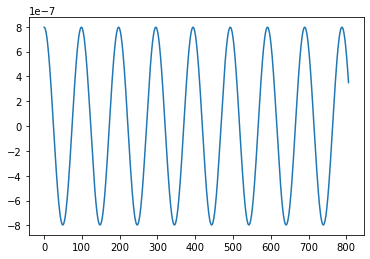

In [8]:
if myid == 0:
    print('air cuts made, line 310')

#define sine-exponential wave excitation

timeVec=np.linspace(0,runtime,Tsteps)

#MPI EJW Section #3 changes
#radius
r=3
inputx=2
inputy=int(gw1/2)
inputz=int(gh1/2)

# get loc by formula

inputid=int(inputx / npx)
inputlocx=int(inputx - inputid*npx+1)

if (myid == 0) :
    print("line 369: glb inputx, local inputx id, local inputx:  ",inputx,inputid,inputlocx)


szzConst=2*ts/(gs*rho1)

amp=10000
decayRate= 0
sinConst=ts*amp/rho1

sinInputSignal=sinConst*np.cos(2*np.pi*frequency*timeVec)*np.exp(-decayRate*timeVec)

fig = plt.figure()
plt.plot(sinInputSignal)
plt.show()

In [9]:
# MPI EJW Section #4 changes 

#initialize fields
vx=np.zeros((npx,gw1,gh1))
vy=np.zeros((npx,gw1,gh1))
vz=np.zeros((npx,gw1,gh1))

sxx=np.zeros((npx,gw1,gh1))
syy=np.zeros((npx,gw1,gh1))
szz=np.zeros((npx,gw1,gh1))
sxy=np.zeros((npx,gw1,gh1))
sxz=np.zeros((npx,gw1,gh1))
syz=np.zeros((npx,gw1,gh1))

#record the signal at a specified location
### ADD map function for this
signalLocx=int(gl1/2)
signalLocy=int(gw1/2)
signalLocz=int(gh1/2)

vxSignal=np.zeros(Tsteps)
vySignal=np.zeros(Tsteps)
vzSignal=np.zeros(Tsteps)

# Grab splits and offsets for scattering arrays
# Only thing to scatter is matPropsglob
# v's and s's are zero to start + source applied later 
# in single proc's array
'''
if myid == 0:
    split=np.zeros(nprocs)
    split[:]=gw1*gh1*npx

    offset=np.zeros(nprocs)
    for i in range(nprocs):
        offset[i]=i*gw1*gh1*npx
else:
    split=None
    offset=None

split=mpi_comm.bcast(split)
offset=mpi_comm.bcast(offset)
'''

matProps0 = np.zeros((npx,gw1,gh1))
matProps1 = np.zeros((npx,gw1,gh1))
matProps2 = np.zeros((npx,gw1,gh1))
matProps3 = np.zeros((npx,gw1,gh1))
signalloc = np.zeros((npx,gw1,gh1))
'''
mpi_comm.Scatterv([matPropsglob[0,:,:,:],split,offset,MPI.DOUBLE], matProps0)
mpi_comm.Scatterv([matPropsglob[1,:,:,:],split,offset,MPI.DOUBLE], matProps1)
mpi_comm.Scatterv([matPropsglob[2,:,:,:],split,offset,MPI.DOUBLE], matProps2)
mpi_comm.Scatterv([matPropsglob[3,:,:,:],split,offset,MPI.DOUBLE], matProps3)
mpi_comm.Scatterv([signalLocation[:,:,:],split,offset,MPI.DOUBLE], signalloc)


matProps0=distBox(matProps0,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
matProps1=distBox(matProps1,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
matProps2=distBox(matProps2,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
matProps3=distBox(matProps3,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
signalloc=distBox(signalloc,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
'''
matProps0=matPropsglob[0,:,:,:]
matProps1=matPropsglob[1,:,:,:]
matProps2=matPropsglob[2,:,:,:]
matProps3=matPropsglob[3,:,:,:]
signalloc=signalLocation[:,:,:]


#Now slab has local versions with ghosts of matProps
if (myid == 0) :
    print('split matprops to globs, scratttered parameters to processors, line 449')



stime = time.time()

if (myid == 0 ):
    print('subs setup, line 1213.  About to start at ' + str(stime))
    

split matprops to globs, scratttered parameters to processors, line 449
subs setup, line 1213.  About to start at 1686599865.1829152


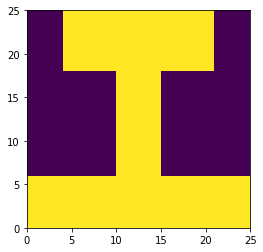

In [10]:
fig = plt.figure(figsize=(4,4))
plt.pcolormesh(matProps0[0,:,:].T)
plt.show()


In [11]:
np.set_printoptions(linewidth=128)


In [12]:
print(np.fliplr(matProps3[xmax-1,:,:]).T)


[[99. 99. 99. 99. 13.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2. 14. 99. 99. 99.]
 [99. 99. 99. 99.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4. 99. 99. 99.]
 [99. 99. 99. 99.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4. 99. 99. 99.]
 [99. 99. 99. 99.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4. 99. 99. 99.]
 [99. 99. 99. 99.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4. 99. 99. 99.]
 [99. 99. 99. 99.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4. 99. 99. 99.]
 [99. 99. 99. 99.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4. 99. 99. 99.]
 [99. 99. 99. 99.  9.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1. 10. 99. 99. 99.]
 [99. 99. 99. 99. 99. 99. 99. 99. 99. 99.  3.  0.  0.  0.  0.  4. 99. 99. 99. 99. 99. 99. 99. 99. 99.]
 [99. 99. 99. 99. 99. 99. 99. 99. 99. 99.  3.  0.  0.  0.  0.  4. 99. 99.

In [13]:
#asdfadsf


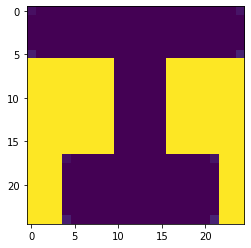

In [14]:
fig, ax = plt.subplots()

im = ax.imshow(matProps3[0,:,:])

def init():
    im.set_data(matProps3[0,:,:])
    return (im,)

# animation function. This is called sequentially
def animate(i):
    data_slice = matProps3[i,:,:].T
    im.set_data(data_slice)
    return (im,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True) 
anim.save('Rail.BCs.gif', writer='imagemagick', fps=30)


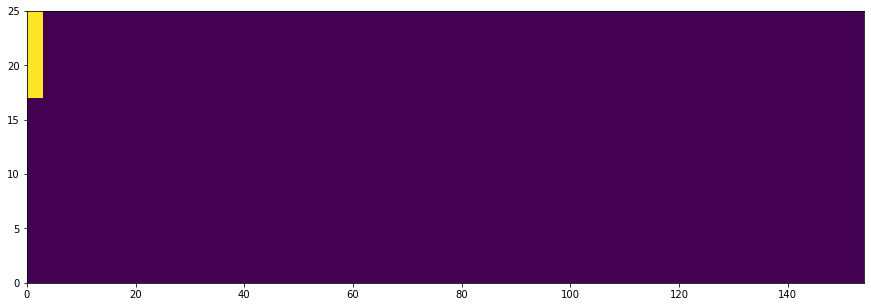

In [15]:
fig = plt.figure(figsize=(15,5))
#plt.pcolormesh(matPropsglob[3,:,1,:].T)
plt.pcolormesh(signalloc[:,gridStartHeadWidth+1,:].T)
plt.show()

In [16]:
print(np.fliplr(signalLocation[0:25,gridStartHeadWidth,:]).T)

[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [17]:
# asdfasdf

In [18]:
for t in range(0,12):#Tsteps):

    if FFunction == 2:
        vz += signalloc * sinInputSignal[t]
    print(np.sum(vz))
    for x in range(npx):
        for y in range(gw1):
            for z in range(gh1):
                updateStress(x,y,z)

    # cut boundaries off of arrays
    '''Remove for Jupyter single processor
    sxxt=sxx[1:npx+1,:,:]
    syyt=syy[1:npx+1,:,:]
    szzt=szz[1:npx+1,:,:]
    sxyt=sxy[1:npx+1,:,:]
    sxzt=sxz[1:npx+1,:,:]
    syzt=syz[1:npx+1,:,:]

    # redistrubute ghost/boundary values
    sxx=distBox(sxxt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    syy=distBox(syyt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    szz=distBox(szzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    sxy=distBox(sxyt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    sxz=distBox(sxzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    syz=distBox(syzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    '''
    
    #if the forcing function is a stress
    if FFunction == 1:
        szz -= signalloc * specificWheelLoad

    for x in range(1,npx):
        for y in range(gw1):
            for z in range(gh1):
                updateVelocity(x,y,z)

    '''Remove for Jupyter single processor
    # cut boundaries off of arrays
    vxt=vx[1:npx+1,:,:]
    vyt=vy[1:npx+1,:,:]
    vzt=vz[1:npx+1,:,:]

    # redistrubute ghost/boundary values
    vx=distBox(vxt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    vy=distBox(vyt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    vz=distBox(vzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        

    #record signals
    if (myid==signalLocxid) :
        vxSignal[t]=vx[signalLocxlocx,signalLocy,signalLocz]
        vySignal[t]=vy[signalLocxlocx,signalLocy,signalLocz]
        vzSignal[t]=vz[signalLocxlocx,signalLocy,signalLocz]
    '''
    
    # save vx cut figure
    # ADD GATHER for plotting

    vzg = vz # np.zeros((gl1,gw1,gh1))
    if t%10==0:
        #vzt=vz
        #mpi_comm.Gatherv(vzt,[vzg,split,offset,MPI.DOUBLE])
        if (myid == 0 ) :
            fig=plt.figure()
            plt.contourf(np.transpose(vzg[:,:,int(gh1/2)]), cmap='seismic')
            plt.savefig(imFolder+'Mid/vzmidCut'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(vzg[:,int(gw1/2),:]), cmap='seismic')
            plt.savefig(imFolder + 'Vert/vzVertCut'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)  
    

            

    # Collect vx, sxx checksum contributions for printing
    vxt=vz#[1:npx+1,:,:]
    sxxt=szz#[1:npx+1,:,:]

    ckvs=np.array(0.0,'d')
    ckss=np.array(0.0,'d')
    
    ckv=np.sum(np.absolute(vxt))
    cks=np.sum(np.absolute(sxxt))
    #mpi_comm.Reduce(ckv,ckvs,op=MPI.SUM,root=0)
    #mpi_comm.Reduce(cks,ckss,op=MPI.SUM,root=0)

    if (myid == 0 ):
        print(t,'/',Tsteps-1,'checksums vx, sxx:',ckvs,ckss, time.time()-stime)
    sys.stdout.flush()

'''
if (myid == signalLocxid) :
    plt.clf()
    plt.plot(vxSignal)
    plt.savefig('vxsignal.png')

if (myid == signalLocxid) :
    plt.clf()
    plt.plot(vySignal)
    plt.savefig('vysignal.png')

if (myid == signalLocxid) :
    plt.clf()
    plt.plot(vzSignal)
    plt.savefig('vzsignal.png')
'''

5.732643938628318e-05
0 / 806 checksums vx, sxx: 0.0 0.0 14.405984878540039
0.00011453643704160103
1 / 806 checksums vx, sxx: 0.0 0.0 18.031806230545044
0.0001713975825379966
2 / 806 checksums vx, sxx: 0.0 0.0 21.63642430305481
0.00022767888262777638
3 / 806 checksums vx, sxx: 0.0 0.0 25.50705313682556
0.0002831574508265539
4 / 806 checksums vx, sxx: 0.0 0.0 29.102643728256226
0.00033762642782066024
5 / 806 checksums vx, sxx: 0.0 0.0 32.69772458076477
0.0003908867572988072
6 / 806 checksums vx, sxx: 0.0 0.0 36.298044204711914
0.0004427245429289352
7 / 806 checksums vx, sxx: 0.0 0.0 39.90179753303528
0.0004929037167794609
8 / 806 checksums vx, sxx: 0.0 0.0 43.49904441833496
0.0005411870181073039
9 / 806 checksums vx, sxx: 0.0 0.0 47.09798979759216
0.0005873580058189808
10 / 806 checksums vx, sxx: 0.0 0.0 50.85433316230774
0.0006312050204325547
11 / 806 checksums vx, sxx: 0.0 0.0 54.436185121536255


"\nif (myid == signalLocxid) :\n    plt.clf()\n    plt.plot(vxSignal)\n    plt.savefig('vxsignal.png')\n\nif (myid == signalLocxid) :\n    plt.clf()\n    plt.plot(vySignal)\n    plt.savefig('vysignal.png')\n\nif (myid == signalLocxid) :\n    plt.clf()\n    plt.plot(vzSignal)\n    plt.savefig('vzsignal.png')\n"